In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [3]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)




Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [4]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

In [5]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [6]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

194

In [7]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


In [8]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

<ipython-input-8-59019010fc55>:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
<ipython-input-8-59019010fc55>:7: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]


In [9]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [ ]:
train_p2 = train.pivot(index='time_id', columns='stock_id', values='log_return1_realized_volatility')
train_p2 = train_p2.fillna(train_p2.mean())


test_p2 = test.pivot(index='time_id', columns='stock_id', values='log_return1_realized_volatility')
if len(test_p2)<=20:
    test_p2[0] = [0.001,0.222,0.333]
    test_p2 = pd.concat([train_p2.head(20),test_p2])
test_p2 = test_p2.fillna(test_p2.mean())

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(train_p2)
neighb = nbrs.kneighbors(train_p2,  return_distance=False)
neighb_dict = {}
for i,x in enumerate(train_p2.index):
    sss = train_p2.index
    neighb_dict[sss[neighb[i][0]]] = [sss[neighb[i][1]],sss[neighb[i][2]], sss[neighb[i][3]], sss[neighb[i][4]]]
    
timecols = ['log_return1_realized_volatility','total_volume_sum',\
           'trade_size_sum','trade_order_count_sum','price_spread_sum',\
           'bid_spread_sum','ask_spread_sum']

from tqdm import tqdm
train2 = []
for xx in tqdm(train.groupby('time_id')):
    tmp = train[train.time_id.isin(neighb_dict[xx[0]][:2])]
    tmp2 = xx[1]
    tmp3 = tmp.groupby('stock_id')[timecols].mean()
    tmp3.columns = [str(xx)+'_c2' for xx in tmp3.columns]
    tmp3 = tmp3.reset_index()
    tmp2 = pd.merge(tmp2,tmp3,how='left',on='stock_id')
    train2.append(tmp2)
train2 = pd.concat(train2).reset_index(drop=True)


from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(test_p2)
neighb = nbrs.kneighbors(test_p2,  return_distance=False)
neighb_dict_test = {}
for i,x in enumerate(test_p2.index):
    sss = test_p2.index
    neighb_dict_test[sss[neighb[i][0]]] = [sss[neighb[i][1]],sss[neighb[i][2]], sss[neighb[i][3]], sss[neighb[i][4]]]
    

 97%|█████████▋| 3717/3830 [01:39<00:02, 38.83it/s]

In [ ]:

test2 = []
for xx in tqdm(test.groupby('time_id')):
    tmp = test[test.time_id.isin(neighb_dict_test[xx[0]][:2])]
    tmp2 = xx[1]
    tmp3 = tmp.groupby('stock_id')[timecols].mean()
    tmp3.columns = [str(xx)+'_c2' for xx in tmp3.columns]
    tmp3 = tmp3.reset_index()
    tmp2 = pd.merge(tmp2,tmp3,how='left',on='stock_id')
    test2.append(tmp2)
test2 = pd.concat(test2).reset_index(drop=True)

train = train2.copy()
test = test2.copy()

In [ ]:
import gc
del mat1,mat2
gc.collect()

Early stopping, best iteration is:
[317]	training's rmse: 0.000410981	training's RMSPE: 0.189942	valid_1's rmse: 0.000454838	valid_1's RMSPE: 0.211676
Training fold 4
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000417612	training's RMSPE: 0.193238	valid_1's rmse: 0.000455449	valid_1's RMSPE: 0.210953
Early stopping, best iteration is:
[393]	training's rmse: 0.000404337	training's RMSPE: 0.187095	valid_1's rmse: 0.000454272	valid_1's RMSPE: 0.210408
Training fold 5
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000417258	training's RMSPE: 0.19364	valid_1's rmse: 0.00045415	valid_1's RMSPE: 0.207874
Early stopping, best iteration is:
[251]	training's rmse: 0.000417166	training's RMSPE: 0.193597	valid_1's rmse: 0.000454094	valid_1's RMSPE: 0.207849
Our out of folds RMSPE is 0.2137742834339639


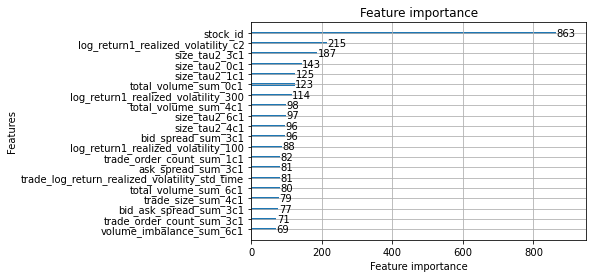

In [13]:
from sklearn.model_selection import GroupKFold,KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.03,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.03,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfoldgroup = GroupKFold(n_splits = 5)
    for fold, (trn_ind, val_ind) in enumerate(kfoldgroup.split(range(len(train)),train.target,train.time_id)):

        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb= train_and_evaluate_lgb(train, test,params0)
test['target'] = predictions_lgb
test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [14]:
train.shape[1]

258

In [15]:

from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')


In [16]:
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]

In [17]:
#colNames.remove('row_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)


In [18]:
train_nn[['stock_id','time_id','target']]=train[['stock_id','time_id','target']]
test_nn[['stock_id','time_id']]=test[['stock_id','time_id']]

In [19]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train_nn.loc[train_nn['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test_nn.loc[test_nn['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


In [20]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 

In [21]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

<ipython-input-21-79e19df2b5ab>:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
<ipython-input-21-79e19df2b5ab>:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]


In [22]:
import gc
train_nn = pd.merge(train_nn,mat1[nnn],how='left',on='time_id')
test_nn = pd.merge(test_nn,mat2[nnn],how='left',on='time_id')
del mat1,mat2
del train,test
gc.collect()

0

In [24]:

timecols = ['log_return1_realized_volatility','total_volume_sum',\
           'trade_size_sum','trade_order_count_sum','price_spread_sum',\
           'bid_spread_sum','ask_spread_sum','volume_imbalance_sum',\
           'bid_ask_spread_sum','size_tau2']
train_p2 = train_nn.pivot(index='time_id', columns='stock_id', values='log_return1_realized_volatility')
train_p2 = train_p2.fillna(train_p2.mean())

test_p2 = test_nn.pivot(index='time_id', columns='stock_id', values='log_return1_realized_volatility')
if len(test_p2)<10:
    test_p2[0] = [0.1,0.2,0.3]
    test_p2 = pd.concat([train_p2.head(10),test_p2])
test_p2 = test_p2.fillna(test_p2.mean())

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(train_p2)
neighb = nbrs.kneighbors(train_p2,  return_distance=False)
neighb_dict = {}
for i,x in enumerate(train_p2.index):
    sss = train_p2.index
    neighb_dict[sss[neighb[i][0]]] = [sss[neighb[i][1]],sss[neighb[i][2]], sss[neighb[i][3]], sss[neighb[i][4]]]
    

    
from tqdm import tqdm
train2_nn = []
for xx in tqdm(train_nn.groupby('time_id')):
    tmp = train_nn[train_nn.time_id.isin(neighb_dict[xx[0]][:2])]
    tmp2 = xx[1]
    tmp3 = tmp.groupby('stock_id')[timecols].mean()
    tmp3.columns = [str(xx)+'_c2' for xx in tmp3.columns]
    tmp3 = tmp3.reset_index()
    tmp2 = pd.merge(tmp2,tmp3,how='left',on='stock_id')
    train2_nn.append(tmp2)
train2_nn = pd.concat(train2_nn).reset_index(drop=True)




100%|██████████| 3/3 [00:00<00:00, 120.81it/s]


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(test_p2)
neighb = nbrs.kneighbors(test_p2,  return_distance=False)
neighb_dict_test = {}
for i,x in enumerate(test_p2.index):
    sss = test_p2.index
    neighb_dict_test[sss[neighb[i][0]]] = [sss[neighb[i][1]],sss[neighb[i][2]], sss[neighb[i][3]], sss[neighb[i][4]]]
    
timecols = ['log_return1_realized_volatility','total_volume_sum',
            'trade_size_sum','trade_order_count_sum','price_spread_sum',
            'bid_spread_sum','ask_spread_sum','volume_imbalance_sum',
            'bid_ask_spread_sum','size_tau2']


from tqdm import tqdm
test2_nn = []
for xx in tqdm(test_nn.groupby('time_id')):
    tmp = test_nn[test_nn.time_id.isin(neighb_dict_test[xx[0]][:2])]
    tmp2 = xx[1]
    tmp3 = tmp.groupby('stock_id')[timecols].mean()
    tmp3.columns = [str(xx)+'_c2' for xx in tmp3.columns]
    tmp3 = tmp3.reset_index()
    tmp2 = pd.merge(tmp2,tmp3,how='left',on='stock_id')
    test2_nn.append(tmp2)
test2_nn = pd.concat(test2_nn).reset_index(drop=True)

train_nn = train2_nn.copy()
test_nn = test2_nn.copy()

In [25]:
test_nn.head()

,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,...,log_return1_realized_volatility_c2,total_volume_sum_c2,trade_size_sum_c2,trade_order_count_sum_c2,price_spread_sum_c2,bid_spread_sum_c2,ask_spread_sum_c2,volume_imbalance_sum_c2,bid_ask_spread_sum_c2,size_tau2_c2
0,-5.199338,-2.42037,-5.199338,-2.718881,-5.199338,-2.714908,-5.199338,-3.7379,-3.419138,-3.471546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.419138,-5.199338,-2.998801,-3.227075,-5.199337,-5.199337,5.199337,-5.199338,-5.199337,3.215717
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.419138,-5.199338,-2.998801,-3.227075,-5.199337,-5.199337,5.199337,-5.199338,-5.199337,3.215717


In [29]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from tensorflow.keras.layers import Activation

hidden_units = (192,96,48)
stock_embedding_size = 24

cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(len(features_to_consider)-1,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation=Activation(swish))(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model


In [30]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [31]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train_nn)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train_nn[features_to_consider] = train_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())
test_nn[features_to_consider] = test_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())

train_nn[pred_name] = 0
test_nn[target_name] = 0
test_predictions_nn = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), features_to_consider]
    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    X_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), features_to_consider]
    y_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.005),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 2s 6ms/step - loss: 9.0549 - val_loss: 1.4272
Epoch 2/1000
168/168 [==============================] - 1s 4ms/step - loss: 1.0188 - val_loss: 0.6721
Epoch 3/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.5777 - val_loss: 0.3678
Epoch 4/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.6811 - val_loss: 0.7103
Epoch 5/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.9867 - val_loss: 0.4896
Epoch 6/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.8904 - val_loss: 0.9493
Epoch 7/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.7375 - val_loss: 0.5948
Epoch 8/1000
168/168 [==============================] - 1s 4ms/step - loss: 1.1410 - val_loss: 0.7909
Epoch 9/1000
168/168 [==============================] - 1s 4ms/step - loss: 0.6072 - val_loss: 0.6158
Epoch 10/1000
168/168 [==============================] - 1s 4ms/step - loss

KeyboardInterrupt: 

In [ ]:
test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str) 
test_nn[target_name] = test_predictions_nn*0.55+predictions_lgb*0.45

score = round(rmspe(y_true = train_nn[target_name].values, y_pred = train_nn[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test_nn[['row_id', target_name]].head(3))
test_nn[['row_id', target_name]].to_csv('submission.csv',index = False)